## Classifying 120 Dog Breeds - CNNs
Techniques used and skills demonstrated:
* Deep Learning
* Python/Tensorflow/Keras
* Exploratory Data Analysis
* Convolutional Neural Networks
* Visualization

## Introduction
I wanted to try a simple deep learning style/format of a project, and when I saw that Stanford had collected and made public a dataset that contained over 20000 images of dogs representing 120 different breeds, I definitely wanted to give it a spin. 

After getting halfway through the project, whilst exploring, debugging, etc., I realized that this dataset is in fact pretty old and I had just never heard of it before! It was even a competition on Kaggle at one point...but I decided to press on because of my own interest, and I thought that even if the dataset was relatively old, if I had never heard of it until 2019, hopefully others haven't either and can gain something from this. It is certainly much better than beating the old Boston Housing Market or Titanic dataset even further into the Earth's core... (jk, but not really)

The dataset can be found and downloaded here: http://vision.stanford.edu/aditya86/ImageNetDogs/, but is also copied into the Github repo for ease of use. We'll kick things off here with just looking at what the data has to offer!

## EDA - Exploratory Data Analysis
First up, we need some tools, and then we can look at some of the images provided in the dataset and move forward from there.

In [241]:
# get our main tools
import numpy as np
import pandas as pd
from glob import glob
import pandas as pd
import scipy.io
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# tools added as needed - probably won't need all of these but they are there
from keras.utils import np_utils
import datetime as dt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from keras.utils import to_categorical
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from sklearn.utils import shuffle
from keras.optimizers import Adam
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Activation, Dense, Flatten, Input, ZeroPadding2D
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from IPython.display import display
from PIL import ImageFile
import PIL
ImageFile.LOAD_TRUNCATED_IMAGES = True 

In [2]:
# see what we have
os.listdir('.')

['annotation.tar',
 '.DS_Store',
 'Dog_Classifier.ipynb',
 'lists',
 'lists.tar',
 'Images',
 'test_data.mat',
 'images.tar',
 'Annotation',
 'train_data.mat',
 'README.txt',
 '.ipynb_checkpoints']

Immediately, we can already see that we don't really need ALL of these contents. Specifically,
* annotation.tar has been extracted and can be ignored
* .DS_Store can be ignored
* Dog_Classifier.ipynb is this notebook obviously
* lists contains:
    * file_list.mat - list of all files in dataset
    * train_list.mat - list and labels of all training data split
    * test_list.mat - list and labels of all test data split
* lists.tar has been extracted and can be ignored
* Images contains:
    * 120 folders of images for all 120 classes
* test_data.mat contains the feature matrix after histogram intersection kernel has been applied (these were features by Stanford - we don't want to use these and just simply copy everything! We can ignore these for now
* images.tar has been extracted and can be ignored
* Annotation contains bounding box annotations of images - good for analysis and classifications with the use of the bounding box, but for now with simple classification we can ignore
* train_data.mat - see test_data.mat above (ignore)
* README.txt contains all of the information I'm typing out right now! Aka if you read everything - ignore
* .ipynb_checkpoints - trivial ignore

As you can see, we can ignore pretty much 80% of these files as they are either repeats or not needed...specifically, I think that the focus should be on only 2 files in terms of dataset:
* lists
* Images

Lists is really a folder of 3 files, but these 2 folders are more than enough to build our classifier! Now that we have really narrowed this down, we can begin loading in some stuff.

In [3]:
# get the file list from file_list (it contains annotation and label info as well in dict format)
file_list = scipy.io.loadmat('lists/file_list.mat', squeeze_me=True)
file_list["file_list"].shape

(20580,)

In [4]:
# take a look converted to dataframe
df = pd.DataFrame(file_list["file_list"])
print(df.shape)
df.head()

(20580, 1)


,0
0,n02085620-Chihuahua/n02085620_10074.jpg
1,n02085620-Chihuahua/n02085620_10131.jpg
2,n02085620-Chihuahua/n02085620_10621.jpg
3,n02085620-Chihuahua/n02085620_1073.jpg
4,n02085620-Chihuahua/n02085620_10976.jpg


In [5]:
# and combine!
df["label"] = file_list["labels"]
df.columns = ["image", "label"]
df.head()

,image,label
0,n02085620-Chihuahua/n02085620_10074.jpg,1
1,n02085620-Chihuahua/n02085620_10131.jpg,1
2,n02085620-Chihuahua/n02085620_10621.jpg,1
3,n02085620-Chihuahua/n02085620_1073.jpg,1
4,n02085620-Chihuahua/n02085620_10976.jpg,1


In [6]:
# look at distribution
df.label.value_counts()

3      252
10     239
27     232
108    219
20     218
      ... 
98     150
101    150
83     150
4      149
18     148
Name: label, Length: 120, dtype: int64

We see that the class counts range from 148 to 252. This may be a slight concern with skewness of proportion, but overall I think 100 image difference can be taken and put aside for now.

To split this data into train and test sets, we just need to sample over random indexes. The easy part is that since we already know the class proportions, we could even sample into the test set exactly the proportion needed (i.e. take half as many of class 18 into the test set as class 3, our min and max). Both Sklearn and pandas have very easy methods for this.

I'm going to cheat a little bit and just use the train and test splits already provided in the folder, but it is always nice to know the process behind it too!

In [7]:
# do what we did before to the train set
train_list = scipy.io.loadmat('lists/train_list.mat', squeeze_me=True)
train = pd.DataFrame(train_list["file_list"], columns=["image"])
train["labels"] = train_list["labels"]
print(train.shape)
train.head()

(12000, 2)


,image,labels
0,n02085620-Chihuahua/n02085620_5927.jpg,1
1,n02085620-Chihuahua/n02085620_4441.jpg,1
2,n02085620-Chihuahua/n02085620_1502.jpg,1
3,n02085620-Chihuahua/n02085620_1916.jpg,1
4,n02085620-Chihuahua/n02085620_13151.jpg,1


In [8]:
# ...and test set
test_list = scipy.io.loadmat('lists/test_list.mat', squeeze_me=True)
test = pd.DataFrame(test_list["file_list"], columns=["image"])
test["labels"] = test_list["labels"]
print(test.shape)
test.head()

(8580, 2)


,image,labels
0,n02085620-Chihuahua/n02085620_2650.jpg,1
1,n02085620-Chihuahua/n02085620_4919.jpg,1
2,n02085620-Chihuahua/n02085620_1765.jpg,1
3,n02085620-Chihuahua/n02085620_3006.jpg,1
4,n02085620-Chihuahua/n02085620_1492.jpg,1


Now, let's create some functions to read in our image given a path to transform it into a tensor that we can actually pass into models.

In [9]:
# for an example
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

# for all images 
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

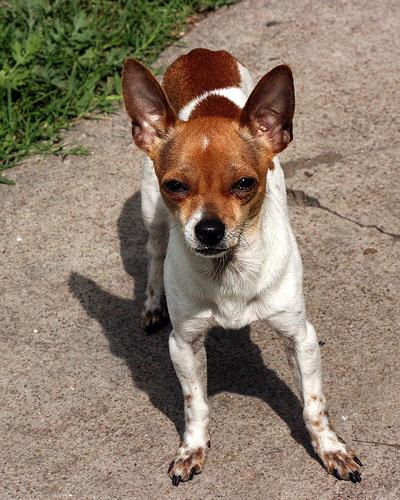

In [10]:
# can we see an example?
example = Image(filename='Images/n02085620-Chihuahua/n02085620_242.jpg')
example

In [11]:
# that chihuahua's up to no good! In tensor form:
example_tensor = path_to_tensor('Images/n02085620-Chihuahua/n02085620_242.jpg')
print(example_tensor.shape)
example_tensor

(1, 224, 224, 3)


array([[[[ 86.,  79.,  53.],
         [112., 106.,  82.],
         [112., 106.,  82.],
         ...,
         [173., 151., 138.],
         [177., 155., 142.],
         [171., 149., 136.]],

        [[110., 100.,  73.],
         [109.,  99.,  74.],
         [127., 117.,  92.],
         ...,
         [169., 147., 134.],
         [179., 157., 144.],
         [167., 145., 132.]],

        [[125., 122.,  91.],
         [107., 104.,  73.],
         [ 79.,  74.,  45.],
         ...,
         [160., 138., 125.],
         [168., 146., 133.],
         [164., 142., 129.]],

        ...,

        [[184., 164., 153.],
         [179., 161., 149.],
         [188., 174., 161.],
         ...,
         [174., 154., 143.],
         [118.,  98.,  87.],
         [137., 117., 106.]],

        [[177., 159., 149.],
         [167., 149., 139.],
         [152., 134., 124.],
         ...,
         [186., 166., 155.],
         [137., 117., 106.],
         [164., 144., 133.]],

        [[162., 144., 134.],
       

Finally, before building our models, we should note that all paths in our train and test sets omit the "Images/" portion, since images are stored in a separate folder. We'll want to add them now here.

In [12]:
# example
example = 'Images/' + (train["image"][0])
example

'Images/n02085620-Chihuahua/n02085620_5927.jpg'

In [13]:
# whole column
images_concat = 'Images/' + train["image"]
images_concat

0            Images/n02085620-Chihuahua/n02085620_5927.jpg
1            Images/n02085620-Chihuahua/n02085620_4441.jpg
2            Images/n02085620-Chihuahua/n02085620_1502.jpg
3            Images/n02085620-Chihuahua/n02085620_1916.jpg
4           Images/n02085620-Chihuahua/n02085620_13151.jpg
                               ...                        
11995    Images/n02116738-African_hunting_dog/n02116738...
11996    Images/n02116738-African_hunting_dog/n02116738...
11997    Images/n02116738-African_hunting_dog/n02116738...
11998    Images/n02116738-African_hunting_dog/n02116738...
11999    Images/n02116738-African_hunting_dog/n02116738...
Name: image, Length: 12000, dtype: object

In [14]:
train["image"] = images_concat
train.head()

,image,labels
0,Images/n02085620-Chihuahua/n02085620_5927.jpg,1
1,Images/n02085620-Chihuahua/n02085620_4441.jpg,1
2,Images/n02085620-Chihuahua/n02085620_1502.jpg,1
3,Images/n02085620-Chihuahua/n02085620_1916.jpg,1
4,Images/n02085620-Chihuahua/n02085620_13151.jpg,1


In [15]:
# repeat for test
images_concat = 'Images/' + test["image"]
test["image"] = images_concat
test.head()

,image,labels
0,Images/n02085620-Chihuahua/n02085620_2650.jpg,1
1,Images/n02085620-Chihuahua/n02085620_4919.jpg,1
2,Images/n02085620-Chihuahua/n02085620_1765.jpg,1
3,Images/n02085620-Chihuahua/n02085620_3006.jpg,1
4,Images/n02085620-Chihuahua/n02085620_1492.jpg,1


Onto training! For this classification, we'll be using CNN, or convolutional neural network models. There will be three models total, 2 "created", and 1 pretrained model from keras.

* We will first make a basic architecutre of a LeNet-5 model. This is mainly my curiousity to see how this model will stand when we implement it ourselves using Keras.
* Then, we will make a second basic architecture with just 5 convolutional layers to see how it compares*** to our first model.
* Finally, we will implement our "final" model using a pretrained VGG16 model from keras, as this will obviously be the most powerful of the three. We will then see how each model did compared to a real world evaluation!

*** Note: I got the idea for this second model from somewhere else, unfortunately I lost the link to it and after desperately trying to get it back, this note is all I can do until further digging...

## Building and Training our Models

In [42]:
# first shuffle our rows up
train = shuffle(train)
train.reset_index(inplace=True, drop=True)
train.head()

,image,labels
0,Images/n02093256-Staffordshire_bullterrier/n02...,29
1,Images/n02106550-Rottweiler/n02106550_8611.jpg,84
2,Images/n02099849-Chesapeake_Bay_retriever/n020...,59
3,Images/n02104029-kuvasz/n02104029_4450.jpg,72
4,Images/n02107142-Doberman/n02107142_16217.jpg,86


In [43]:
# make all of our train tensors (NOTE: This takes awhile)
train_tensors = paths_to_tensor(train["image"]).astype('float32')/255

100%|██████████| 12000/12000 [01:33<00:00, 127.72it/s]


In [141]:
# we will need to make our training labels encoded
y_binary = to_categorical(train["labels"])
y_binary

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [45]:
# our very crude version of LeNet-5...

# init
model = Sequential()
model.add(BatchNormalization(input_shape=(224, 224, 3)))

# conv layer 1 + pool 1
model.add(Conv2D(filters=16, kernel_size=3, strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

# conv layer 2 + pool 2
model.add(Conv2D(filters=32, kernel_size=3, strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

# flatten...
model.add(Flatten())

# ...and then FC 1
model.add(Dense(units = 16, activation = 'relu'))

# FC2
model.add(Dense(units = 32, activation = 'relu'))

# outut!
model.add(Dense(121, activation='softmax'))

# look at table
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_22 (Batc (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 54, 54, 32)        128       
__________

In [46]:
# let's try these parameters...
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
# train!
model.fit(train_tensors, y_binary, validation_split=0.1, epochs=30)

Train on 10800 samples, validate on 1200 samples
Epoch 1/30
10800/10800 [==============================] - 561s 52ms/step - loss: 5.0832 - acc: 0.0076 - val_loss: 4.7976 - val_acc: 0.0067
Epoch 2/30
10800/10800 [==============================] - 532s 49ms/step - loss: 4.7452 - acc: 0.0165 - val_loss: 4.7736 - val_acc: 0.0117
Epoch 3/30
10800/10800 [==============================] - 474s 44ms/step - loss: 4.6646 - acc: 0.0204 - val_loss: 4.7224 - val_acc: 0.0142
Epoch 4/30
10800/10800 [==============================] - 460s 43ms/step - loss: 4.5980 - acc: 0.0216 - val_loss: 4.6987 - val_acc: 0.0100
Epoch 5/30
10800/10800 [==============================] - 482s 45ms/step - loss: 4.5354 - acc: 0.0282 - val_loss: 4.7034 - val_acc: 0.0125
Epoch 6/30
10800/10800 [==============================] - 468s 43ms/step - loss: 4.4665 - acc: 0.0360 - val_loss: 4.7584 - val_acc: 0.0167
Epoch 7/30
10800/10800 [==============================] - 469s 43ms/step - loss: 4.3849 - acc: 0.0431 - val_loss: 4.7

KeyboardInterrupt: 

As you can see from the KeyboardInterrupt above, I stopped this manually because clearly we were not getting anywhere LOL. The training accuracy barely eclipsed 5% and the validation accuracy didn't even sniff 2%, so clearly something was off here. 

I kind of expected this anyway from a very basic model with no care about hyperparameters or anything else, but nonetheless it's always a good baseline to start a model from the get-go and see what happens. With that being said, I really don't want to fine tune and focus on a 5% model, so let's move on...

Here we start our new model that has more convolutional layers:

In [48]:
# new init
model = Sequential()
model.add(BatchNormalization(input_shape=(224, 224, 3)))

# new conv 1
model.add(Conv2D(filters=16, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

# conv 2
model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

# conv 3
model.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

# conv 4
model.add(Conv2D(filters=256, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

# pool and output
model.add(GlobalAveragePooling2D())
model.add(Dense(121, activation='softmax'))

# stats
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_25 (Batc (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 54, 54, 32)        128       
__________

We already see here that even though the model looks more "complex" with more convolutional layers, the number of parameters actually decreased a lot, mainly due to not having any dense layers except the end. Let's see if it works...

In [49]:
# same params
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
# let's get an early stopping callback so we don't have to manually interrupt again
# this stops the fitting when after 3 epochs it doesn't look like any further improvement will happen
early_stopping_monitor = EarlyStopping(patience=3)
# train!
model.fit(train_tensors, y_binary, validation_split=0.2, epochs=30, callbacks=[early_stopping_monitor])

Train on 9600 samples, validate on 2400 samples
Epoch 1/30
9600/9600 [==============================] - 548s 57ms/step - loss: 4.5616 - acc: 0.0370 - val_loss: 4.4963 - val_acc: 0.0517
Epoch 2/30
9600/9600 [==============================] - 549s 57ms/step - loss: 4.1631 - acc: 0.0755 - val_loss: 4.2413 - val_acc: 0.0775
Epoch 3/30
9600/9600 [==============================] - 542s 56ms/step - loss: 3.8657 - acc: 0.1224 - val_loss: 3.9347 - val_acc: 0.1017
Epoch 4/30
9600/9600 [==============================] - 545s 57ms/step - loss: 3.5942 - acc: 0.1610 - val_loss: 3.9555 - val_acc: 0.1092
Epoch 5/30
9600/9600 [==============================] - 548s 57ms/step - loss: 3.3356 - acc: 0.2108 - val_loss: 3.6319 - val_acc: 0.1396
Epoch 6/30
9600/9600 [==============================] - 540s 56ms/step - loss: 3.0541 - acc: 0.2670 - val_loss: 3.5105 - val_acc: 0.1796
Epoch 7/30
9600/9600 [==============================] - 549s 57ms/step - loss: 2.7729 - acc: 0.3295 - val_loss: 3.5242 - val_acc: 

Okay, okay... so we got up to around 65% accuracy this time, which is a MASSIVE improvement over 5%, but the validation accuracy (the one we care about) is still only about 22%. I probably should have seen this coming with "models" that were implemented in minutes with no real thought. Still, they need to be compared to a 'good' model to be called terrible, don't they? Let's not waste any more time, and introduce our pretrained VGG16 model and see what this guy can do.

In [67]:
# get our base model set up
base_model = VGG16(weights='imagenet', include_top=False, input_shape = (224, 224, 3))
x = base_model.output

# layers
x = Flatten()(x)
x = Dropout(0.4)(x)

x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Dense(2048, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

predictions = Dense(121, activation='softmax')(x)

# model to train
model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# setup
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Even more complex than before! A good buildup to the VGG16, and here we go:

In [ ]:
# let's try using a different Adam optimizer for this one
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:
# set early stopping
early_stopping_monitor = EarlyStopping(patience=3)
# train!
model.fit(train_tensors, y_binary, validation_split=0.1, epochs=30, callbacks=[early_stopping_monitor])

Train on 10800 samples, validate on 1200 samples
Epoch 1/30
10800/10800 [==============================] - 3169s 293ms/step - loss: 5.1001 - acc: 0.0419 - val_loss: 3.9973 - val_acc: 0.1158
Epoch 2/30
10800/10800 [==============================] - 3143s 291ms/step - loss: 3.5823 - acc: 0.1802 - val_loss: 3.4082 - val_acc: 0.1875
Epoch 3/30
10800/10800 [==============================] - 3488s 323ms/step - loss: 2.6825 - acc: 0.3364 - val_loss: 3.1323 - val_acc: 0.2208
Epoch 4/30
10800/10800 [==============================] - 3089s 286ms/step - loss: 2.0419 - acc: 0.4700 - val_loss: 3.0298 - val_acc: 0.2633
Epoch 5/30
10800/10800 [==============================] - 3050s 282ms/step - loss: 1.5714 - acc: 0.5897 - val_loss: 2.9393 - val_acc: 0.2825
Epoch 6/30
10800/10800 [==============================] - 3275s 303ms/step - loss: 1.2126 - acc: 0.6791 - val_loss: 3.0266 - val_acc: 0.2792
Epoch 7/30
10800/10800 [==============================] - 3135s 290ms/step - loss: 0.9108 - acc: 0.7584 -

82% accuracy with 28% validation accuracy! A continuous improvement! While this model was fitting, I suspected taht perhaps shuffling the data at each epoch may be better for training purposes...below I try a couple of epochs with this in the parameters. I couldn't train from scratch because at this point in the process my machine is wheezing lol (you can see each epoch takes over 3000s+, at the time of writing my machine really cannot consistently handle this).

In [69]:
# try new shuffle param
early_stopping_monitor = EarlyStopping(patience=3)
# train!
model.fit(train_tensors, y_binary, validation_split=0.1, epochs=30, shuffle=True, callbacks=[early_stopping_monitor])

Train on 10800 samples, validate on 1200 samples
Epoch 1/30
10800/10800 [==============================] - 3080s 285ms/step - loss: 0.5235 - acc: 0.8674 - val_loss: 3.0730 - val_acc: 0.2917
Epoch 2/30
10800/10800 [==============================] - 3101s 287ms/step - loss: 0.4248 - acc: 0.8908 - val_loss: 3.1316 - val_acc: 0.2800
Epoch 3/30
10800/10800 [==============================] - 3098s 287ms/step - loss: 0.3394 - acc: 0.9155 - val_loss: 3.1138 - val_acc: 0.2900
Epoch 4/30
10800/10800 [==============================] - 3105s 288ms/step - loss: 0.2820 - acc: 0.9299 - val_loss: 3.1919 - val_acc: 0.2883


Oof. I guess it didn't really matter after all, at least at this point in the training process. Now comes the hard part in the data science process: Do we
* Continue and train our test data
* Start a new model and try to get better scores
* Tune the current one

It's hard to say in most cases, and often ends up being intuition. In a perfect world (with perfect resources), I would say that for this project, going back to the current model and feeding it some new features that we engineer along with tuning some of the hyperparameters (optimizer, etc.) will be ideal. Starting a new model (option 2) seems nice, but we really can't get any better than VGG16 at this point (except maybe VGG19, but I really do think VGG16 will suffice). After all, all we really did with the features was convert them into tensors and feed them into the mdoel. We can pad them, generate new images, implement some detectors, etc. etc. to improve this baseline VGG16 model further to get optimal results.

With all of that being said...this will require a lot of testing of different parameters and hyperparameters, and at this point my machine is begging me to stop lol. These are ideas for the future that I would absolutely love to revisit, however, so I'm throwing it out there now. I could test different options with a subset of the training data, but at that point you also introduce variance into the project which is just another headache.

For the purposes of this project at the time of writing, I will go ahead and continue on to train the test data now to see what we get. However, like stated above, some things to consider and revisit (or TODO) are:
* engineer some new features to feed in, perhaps sizing detectors off the top of the head since dogs are different sizes
* make sure the train set is actually split and shuffled in proportion as this can really affect training and fitting(this is more or less geared towards the shuffle part as we took the Stanford training set for granted here - but in other projects splitting is key)
* try out different hyperparameters (I really like the grid approach) with the VGG16 baseline model. I believe this will work best in terms of improvement/time ratio.

## Making Predictions

In [70]:
# shuffle test set
test = shuffle(test)
test.reset_index(inplace=True, drop=True)
test.head()

,image,labels
0,Images/n02097474-Tibetan_terrier/n02097474_509...,50
1,Images/n02091467-Norwegian_elkhound/n02091467_...,24
2,Images/n02099849-Chesapeake_Bay_retriever/n020...,59
3,Images/n02102480-Sussex_spaniel/n02102480_1838...,70
4,Images/n02091032-Italian_greyhound/n02091032_1...,21


In [71]:
# make all of our test tensors
test_tensors = paths_to_tensor(test["image"]).astype('float32')/255

100%|██████████| 8580/8580 [01:09<00:00, 123.74it/s]


In [72]:
# test labels encoded
y_binary_test = to_categorical(test["labels"])
y_binary_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [73]:
# predict...
dog_predictions = model.predict(test_tensors)

In [77]:
# take a look
dog_predictions

array([[1.00062949e-04, 1.00618496e-03, 3.37150656e-02, ...,
        1.57104820e-04, 4.58877366e-06, 3.34013661e-04],
       [1.80271575e-09, 1.02625336e-06, 6.37109698e-10, ...,
        2.86927360e-07, 1.01622621e-09, 1.34093066e-08],
       [4.92381914e-05, 2.17771297e-03, 2.03431002e-03, ...,
        1.48112234e-02, 7.03749433e-03, 4.69539576e-04],
       ...,
       [3.60510930e-05, 2.43598086e-04, 4.95202001e-03, ...,
        1.32496116e-05, 1.17807008e-06, 2.47323078e-06],
       [7.78900085e-06, 2.27169839e-05, 1.59961201e-04, ...,
        7.59195318e-05, 8.28167595e-06, 8.89966304e-06],
       [8.01363713e-05, 1.22398298e-04, 6.25213084e-04, ...,
        7.12020672e-04, 1.25639344e-04, 3.15507423e-05]], dtype=float32)

It looks like we have a lot of softmax predictions for our labels - which is good and intended, but for accuracy scoring let's convert to a hard prediction for now:

In [131]:
# convert to categories
real_dog_predictions = np.argmax(dog_predictions, axis=1)
real_dog_predictions

array([ 48,  24,  27, ...,  10,  40, 111])

In [132]:
# get a basic score
acc_score = accuracy_score(test["labels"], real_dog_predictions)
acc_score

0.28939393939393937

## Interpretations

As expected, we ended up only getting around 28% accuracy total for the test set :(. But silver lining: we have to ask ourselves, is this really that bad?

We have to remember that there are 120 categories, not 2. With a binary classification, we can think of a baseline as 50% accuracy since just guessing will on average yield those results. For 120 categories, just guessing will on average actually lead to 0.833% accuracy, less than 1%! The fact that the model manages to get almost 1 out of every 3 images right based on 120 categories is actually a great start to perfecting it.

Next, we also have to remember that human baseline is also a good marker of accuracy. Now, to an expert dog and canine scientist, our model would obviously fail. They probably get these breeds right 95% of the time or more. But to you and me, and the average person, can we really do better than 28%? 

Take a look at these two examples:

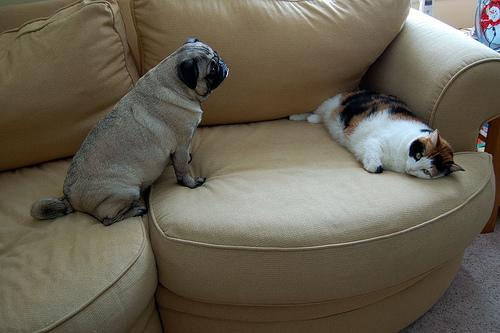

In [89]:
example1 = Image(filename='Images/n02110958-pug/n02110958_340.jpg')
example1

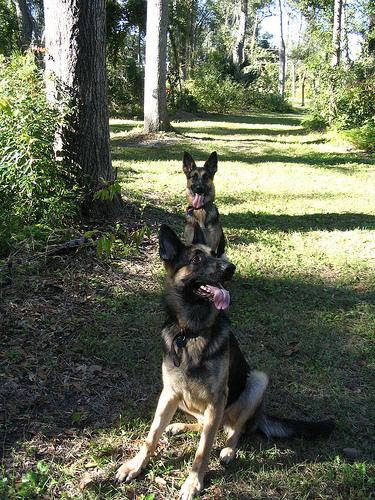

In [90]:
example2 = Image(filename='Images/n02106662-German_shepherd/n02106662_712.jpg')
example2

We can very easily tell that the first example is a Pug and the second example is a German Shepherd, right?*** Now what about these two?

*** Also, in these two images we can also clearly see that the model has to overcome many hardships such as differentiating from the cat in the Pug photo and having to deal with two dogs in the German Shepherd photo. This isn't easy!

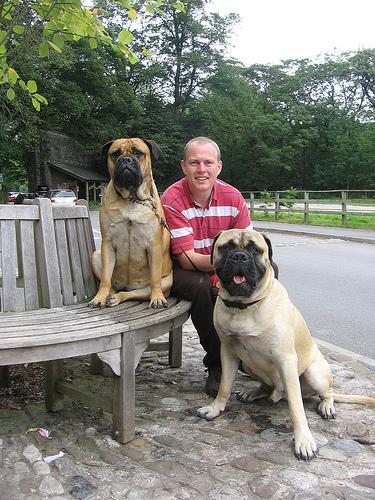

In [91]:
example3 = Image(filename='Images/n02108422-bull_mastiff/n02108422_347.jpg')
example3

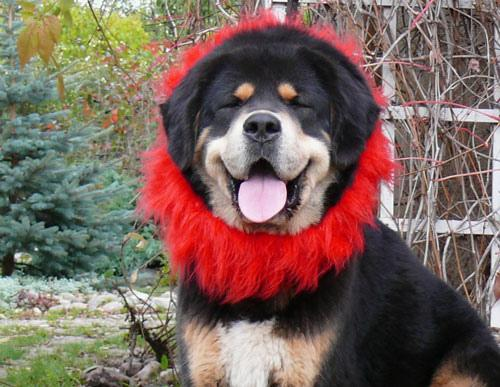

In [94]:
example4 = Image(filename='Images/n02108551-Tibetan_mastiff/n02108551_340.jpg')
example4

Can we really sit here and say that we would be able to easily classify these as a Bull Mastiff and a Tibetan Mastiff, respectively? They look the same to me! And there are 118 other classes to deal with with plenty more examples if you managed to get this one right. 

I would actually guess that 28% would be very good for an average human baseline, so (in an effort to make myself feel better admittedly) at least we can say that our model is on par with the average human intelligence of dogs.

At the end of the day, at least it's very good at classifying things that don't have 10 different variations (Kerry blue terrier, Irish terrier, Norwich terrior, etc. etc.), which is a nice start.

In [229]:
# personal test
example_tensor = path_to_tensor('Images/n02085620-Chihuahua/n02085620_1271.jpg')
personal_prediction = model.predict(example_tensor)
personal_prediction = np.argmax(personal_prediction, axis=1)
personal_prediction

# personal test
example_tensor = path_to_tensor('test_image/test.jpg')
personal_prediction = model.predict(example_tensor)
personal_prediction = np.argmax(personal_prediction, axis=1)
personal_prediction

array([107])

In [230]:
# Samoyed class
train[train["labels"] == 107].head(1)

,image,labels
105,Images/n02111889-Samoyed/n02111889_1255.jpg,107


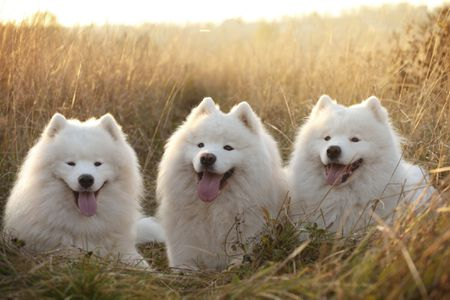

In [231]:
example5 = Image(filename='test_image/test.jpg')
example5

Don't forget that we also have 121 classes instead of 120, with the first class of 0 indicating "None of the other 120", so the model is also quite good at classifying non-dogs, as it turns out.

In [234]:
# personal test
example_tensor = path_to_tensor('test_image/test2.jpg')
personal_prediction = model.predict(example_tensor)
personal_prediction = np.argmax(personal_prediction, axis=1)
personal_prediction

array([0])

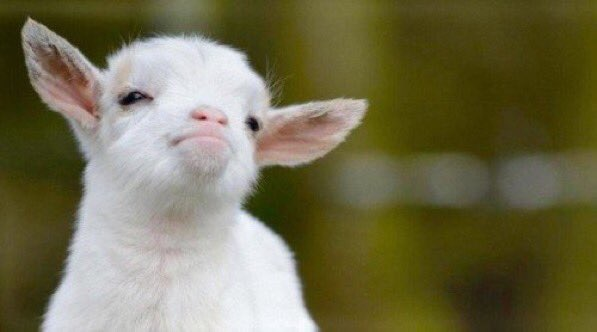

In [235]:
example6 = Image(filename='test_image/test2.jpg')
example6

One final note: during my tests with personal pictures, it seemed as if .png and other files were getting misclassified more than .jpeg and .jpg. This could just be simple randomness, but it does make sense since all of the training data was based on .jpg and something to note for future reference.

Below I have also included a confusion matrix for those interested. From a quick glance you can tell that the model generally tries to get it right (28% of 120 classes is still good, remember) but often gets stuck on a few breeds that may look very similar to each other.

In [239]:
# confusion matrix
confusion = confusion_matrix(test["labels"], real_dog_predictions)
confusion

array([[16,  0,  1, ...,  1,  1,  0],
       [ 0, 44,  0, ...,  0,  0,  1],
       [ 2,  1, 58, ...,  0,  0,  1],
       ...,
       [ 2,  0,  0, ..., 24,  4,  0],
       [ 0,  0,  0, ...,  3, 24,  1],
       [ 0,  0,  0, ...,  1,  3, 51]])

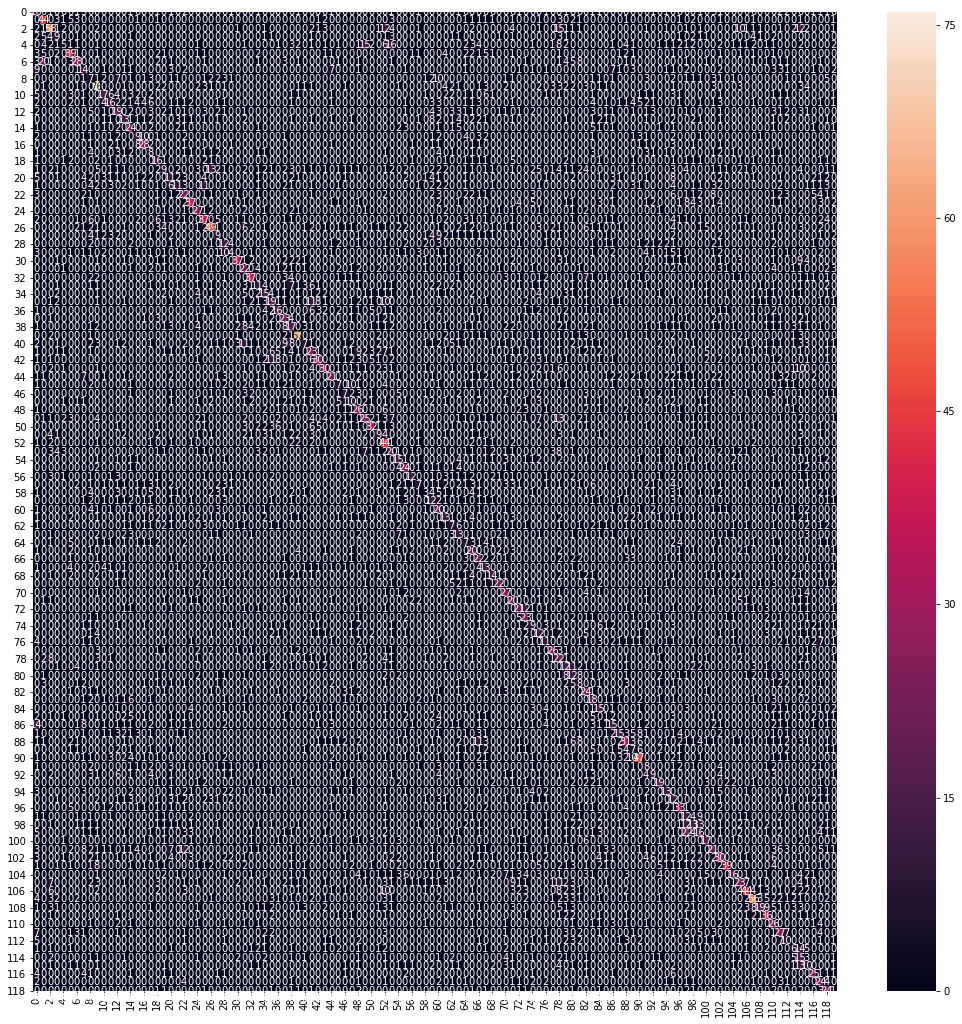

In [247]:
# plot
confusion = pd.DataFrame(confusion, range(120), range(120))
plt.figure(figsize = (18,18))
sns.heatmap(df_cm, annot=True)
plt.show()

## Conclusion and Final Thoughts
All in all, I believe that this was a very nice "first" for me, given that it was my first time classifying anything that had more than 3 classes using machine learning models. A jump from 3 to 120 is huge, but jumping in the deep end is often the best thing to do. I had a lot of fun trying different approaches to different models, and realizing which dog breeds were the most troublesome to work with (I'm look at you, terriers and spaniels).

In the future, when my machine isn't fully dying and can run more extensive tests, as stated above in the notebook, I would love TODO the following:
* try out a grid approach to find the best model parameters
* generate new features to feed into this approach (Now that I have gotten this far, I realize that this is very important. Having different objects such as cats and humans and more than 1 dog in images affects a lot. Also, I realized that just by cropping an image, sometimes the model will predict something different entirely.)
* train more extensively in general

Also on the TODO list that has more to do with analysis rather than machine learning:
* work with the confusion matrix to isolate most troublesome classes
* implement and use the bounding boxes given in the dataset by Stanford for something cool (not sure what yet)
* perhaps even implement an app to go along with this!

It was honestly eye-opening to see just how much harder it is to fully develop and implement a model that could accurately distinguish between these 120 classes. It is nothing like 2 or 3 as shown in introduction examples, and I would love to come back to this and improve even more with some new ideas. Other than that though, I hope others can take this and learn something from it too so they can go on and start building things that classify even more than 120 classes! Let's aim higher.

## References and Helpful Links Used
1) http://vision.stanford.edu/aditya86/ImageNetDogs/ (dataset)

2) https://github.com/saksham789/DOG-BREED-CLASSIFICATION-STANFORD-DOG-DATASET (inspiration)

3) http://machinememos.com/python/keras/artificial%20intelligence/machine%20learning/transfer%20learning/dog%20breed/neural%20networks/convolutional%20neural%20network/tensorflow/image%20classification/imagenet/2017/07/11/dog-breed-image-classification.html (helpful tips)

4) https://keras.io/models/model/ (documentation)

5) https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62 (confusion matrix help)

6) many, many, stackoverflow links, keras pages, and sklearn pages that are too numerous to list (THANK YOU) (trial and error)